In [36]:
import pandas as pd
from pandasql import sqldf
import pyecharts.options as opts
from pyecharts.charts import Bar,Line,Boxplot,Page, WordCloud
import altair as alt
import pandas_profiling
import plotly
import plotly.graph_objs as go
import plotly.express as px
alt.renderers.enable('notebook')
pysqldf = lambda q: sqldf(q, globals())


In [46]:
plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
    "layout": go.Layout(title="hello world")
})

In [3]:
phoneAge = pd.read_csv("/workspace/iphone.csv")
phoneAge = phoneAge.drop(['_id'], axis=1)
phoneAge.head()

,keyword,level1,level2,level3,level4,level5,male,female,date
0,iphone,5,18,54,20,3,66,34,201806|201807
1,iphone,4,18,55,20,3,65,35,201807|201808
2,iphone,5,20,54,18,3,68,32,201808|201809
3,iphone,4,20,54,19,3,66,34,201809|201810
4,iphone,4,19,54,20,3,64,36,201810|201811


In [3]:
phoneAge.profile_report(style={'full_width':True})
profile = phoneAge.profile_report()


# 数据统计

In [79]:
def num_missing(x):
    return sum(x.isnull())
print ("缺失值列:")
print (phoneAge.apply(num_missing, axis=0))
print ("\n缺失值---行:")
print (phoneAge.apply(num_missing, axis=1).head())

缺失值列:
keyword    0
level1     0
level2     0
level3     0
level4     0
level5     0
male       0
female     0
date       0
dtype: int64

缺失值---行:
0    0
1    0
2    0
3    0
4    0
dtype: int64


In [71]:
phoneAge.describe()

,level1,level2,level3,level4,level5,male,female
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,4.245370,15.569444,51.555556,23.615741,5.013889,74.620370,25.379630
std,1.503477,3.661845,2.674021,4.002968,2.394721,7.288369,7.288369
min,1.000000,7.000000,45.000000,13.000000,1.000000,57.000000,9.000000
25%,3.000000,13.000000,50.000000,21.000000,3.000000,69.000000,20.000000
50%,4.000000,16.000000,52.000000,23.000000,4.000000,74.500000,25.500000
75%,5.250000,17.250000,53.000000,27.000000,6.000000,80.000000,31.000000
max,7.000000,26.000000,56.000000,33.000000,14.000000,91.000000,43.000000


# iphone 各年龄折线图

In [5]:
iphone = phoneAge[phoneAge['keyword'] == 'iphone']
iphone.tail()

,keyword,level1,level2,level3,level4,level5,male,female,date
13,iphone,4,15,56,21,4,63,37,201907|201908
14,iphone,5,19,54,19,3,65,35,201908|201909
15,iphone,5,20,54,17,4,65,35,201909|201910
16,iphone,4,17,55,20,4,63,37,201910|201911
17,iphone,4,16,55,20,5,63,37,201911|201912


In [61]:
a= pysqldf("SELECT level1 ,level2,level3 ,level4 ,level5,date  FROM phoneAge where keyword = 'iphone' ;")
a=a.astype({'level1':'int','level2':'int'})
print(a.head())
dic1={'date':a['date'],'level':"0-20",'value':a['level1']}
dic2={'date':a['date'],'level':"20-30",'value':a['level2']}
b=pd.DataFrame(dic1)
c=pd.DataFrame(dic2)
d=c.append(b)
d=d.append(pd.DataFrame({'date':a['date'],'level':"30-40",'value':a['level3']}))
d=d.append(pd.DataFrame({'date':a['date'],'level':"40-50",'value':a['level4']}))
d=d.append(pd.DataFrame({'date':a['date'],'level':"50+",'value':a['level5']}))
d.tail()


   level1  level2  level3  level4  level5           date
0       5      18      54      20       3  201806|201807
1       4      18      55      20       3  201807|201808
2       5      20      54      18       3  201808|201809
3       4      20      54      19       3  201809|201810
4       4      19      54      20       3  201810|201811


,date,level,value
13,201907|201908,50+,4
14,201908|201909,50+,3
15,201909|201910,50+,4
16,201910|201911,50+,4
17,201911|201912,50+,5


## 不同年龄层指数变化折线图

In [62]:
c= (Line()
    .add_xaxis(list(a['date']))
    .add_yaxis("0-20",list(a['level1']))
    .add_yaxis("20-30",list(a['level2']))
    .add_yaxis("30-40",list(a['level3']))
    .add_yaxis("40-50",list(a['level4']))
    .add_yaxis("50+",list(a['level5']))
    .set_global_opts(title_opts=opts.TitleOpts(title="Line-不同年龄层指数变化折线图")))
c.render_notebook()

## 可选择关键词的折线图

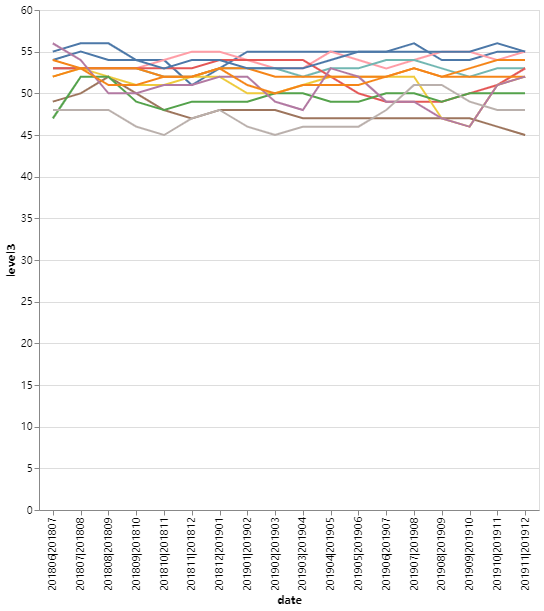

In [47]:
highlight = alt.selection(type='single', on='mouseover',fields=['symbol'], nearest=True)
input_dropdown = alt.binding_select(options=["iphone","华为","小米手机","vivo","oppo","三星","魅族","一加手机","锤子手机","中兴","lg"])
brush = alt.selection_interval(bind='scales')
selection = alt.selection_single(fields=['keyword'], bind=input_dropdown, name='phone brand:')
alt.Chart(phoneAge).mark_line().encode(
    x='date',
    y='level3',
    color=alt.condition(selection,alt.Color('keyword:N', legend=None),alt.value('lightgray'))
).properties(
    width=500,
    height=500
).add_selection(
    brush,
    selection
)


# 各手机品牌指数

In [75]:
phoneAge['totlaValue']=phoneAge['level1']+phoneAge['level2']+phoneAge['level3']+phoneAge['level4']+phoneAge['level5']
phoneAge.head()

,keyword,level1,level2,level3,level4,level5,male,female,date,totlaValue
0,iphone,5,18,54,20,3,66,34,201806|201807,100
1,iphone,4,18,55,20,3,65,35,201807|201808,100
2,iphone,5,20,54,18,3,68,32,201808|201809,100
3,iphone,4,20,54,19,3,66,34,201809|201810,100
4,iphone,4,19,54,20,3,64,36,201810|201811,100


In [9]:
a= pysqldf("SELECT level1 ,level2,level3 ,level4 ,level5,keyword  FROM phoneAge where date='201911|201912';")
a=a.astype({'level1':'int','level2':'int'})
print(a.head())
dic1={'keyword':a['keyword'],'level':"0-20",'value':a['level1']}
dic2={'keyword':a['keyword'],'level':"20-30",'value':a['level2']}
b=pd.DataFrame(dic1)
c=pd.DataFrame(dic2)
d=c.append(b)
d=d.append(pd.DataFrame({'keyword':a['keyword'],'level':"30-40",'value':a['level3']}))
d=d.append(pd.DataFrame({'keyword':a['keyword'],'level':"40-50",'value':a['level4']}))
d=d.append(pd.DataFrame({'keyword':a['keyword'],'level':"50+",'value':a['level5']}))
d.head(10)

   level1  level2  level3  level4  level5 keyword
0       4      16      55      20       5  iphone
1       4      18      55      19       4      华为
2       2      10      45      30      13    小米手机
3       2       9      53      28       8    vivo
4       2       9      53      28       8    oppo


,keyword,level,value
0,iphone,20-30,16
1,华为,20-30,18
2,小米手机,20-30,10
3,vivo,20-30,9
4,oppo,20-30,9
5,三星,20-30,16
6,魅族,20-30,22
7,一加手机,20-30,14
8,锤子手机,20-30,16
9,中兴,20-30,17


## 2019年11月到12月不同年龄层各品牌指数

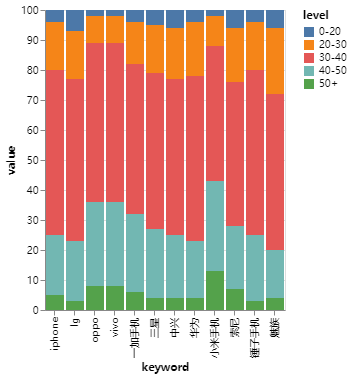

In [10]:
alt.Chart(d).mark_bar().encode(
    x='keyword:O',
    y='value:Q',
    color='level:N'
)

## 华为2018年-2019年指数堆积面积图

In [49]:
h = pysqldf("SELECT level1 ,level2,level3 ,level4 ,level5,date  FROM phoneAge where keyword='华为';")
h.head()

,date,level,value
0,201806|201807,0-20,4
1,201807|201808,0-20,4
2,201808|201809,0-20,4
3,201809|201810,0-20,4
4,201810|201811,0-20,4


In [64]:
c=(
    Line().add_xaxis(list(h['date']))
    .add_yaxis(
        "leve1",list(h['level1']),areastyle_opts=opts.AreaStyleOpts(opacity=0.5)
    )
    .add_yaxis(
        "leve2",list(h['level2']),areastyle_opts=opts.AreaStyleOpts(opacity=0.5)
    )
    .add_yaxis(
        "leve3",list(h['level3']),areastyle_opts=opts.AreaStyleOpts(opacity=0.5)
    )
    .add_yaxis(
        "leve4",list(h['level4']),areastyle_opts=opts.AreaStyleOpts(opacity=0.5)
    )
    .add_yaxis(
        "leve5",list(h['level5']),areastyle_opts=opts.AreaStyleOpts(opacity=0.5)
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="华为不同年龄指数堆积面积图"))
)
c.render_notebook()

# 性别对于手机指数的影响

In [12]:
SexPhone=pysqldf("select male,female,date,keyword from phoneAge;")
SexPhoneNumber = pysqldf("select sum(male) as male,sum(female) as female,keyword from phoneAge group by keyword;")
print(SexPhone.head())
print(SexPhoneNumber.head())

   male  female           date keyword
0    66      34  201806|201807  iphone
1    65      35  201807|201808  iphone
2    68      32  201808|201809  iphone
3    66      34  201809|201810  iphone
4    64      36  201810|201811  iphone
   male  female keyword
0  1157     643  iphone
1  1237     563      lg
2  1168     632    oppo
3  1241     559    vivo
4  1410     390    一加手机


In [17]:
c=(Bar()
   .add_xaxis(list(SexPhoneNumber['keyword']))
   .add_yaxis("男性",list(SexPhoneNumber['male']))
   .add_yaxis("女性",list(SexPhoneNumber['female']))
   .reversal_axis()
   .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
  )

c.render_notebook()

In [40]:
keywords=list(set(SexPhone['keyword']))
v1=[]
for i in keywords:
    ss=SexPhone[SexPhone['keyword']==i]
    v1.append([list(ss['male']),list(ss['female'])])
print(v1)

[[[73, 73, 75, 76, 75, 73, 74, 75, 75, 73, 72, 73, 73, 73, 77, 77, 75, 75], [27, 27, 25, 24, 25, 27, 26, 25, 25, 27, 28, 27, 27, 27, 23, 23, 25, 25]], [[79, 81, 81, 81, 81, 81, 80, 80, 80, 79, 76, 74, 73, 75, 77, 78, 77, 77], [21, 19, 19, 19, 19, 19, 20, 20, 20, 21, 24, 26, 27, 25, 23, 22, 23, 23]], [[73, 76, 76, 72, 73, 74, 73, 74, 74, 74, 75, 74, 74, 75, 78, 81, 79, 72], [27, 24, 24, 28, 27, 26, 27, 26, 26, 26, 25, 26, 26, 25, 22, 19, 21, 28]], [[81, 80, 81, 81, 80, 80, 81, 83, 82, 81, 81, 81, 81, 79, 79, 82, 82, 81], [19, 20, 19, 19, 20, 20, 19, 17, 18, 19, 19, 19, 19, 21, 21, 18, 18, 19]], [[69, 69, 69, 68, 68, 68, 68, 71, 69, 68, 69, 69, 69, 69, 69, 68, 68, 69], [31, 31, 31, 32, 32, 32, 32, 29, 31, 32, 31, 31, 31, 31, 31, 32, 32, 31]], [[73, 74, 74, 77, 77, 74, 73, 75, 76, 74, 73, 72, 72, 74, 77, 77, 76, 78], [27, 26, 26, 23, 23, 26, 27, 25, 24, 26, 27, 28, 28, 26, 23, 23, 24, 22]], [[82, 77, 75, 75, 74, 74, 76, 78, 77, 75, 76, 76, 78, 78, 75, 73, 72, 72], [18, 23, 25, 25, 26, 26,

In [42]:
c = Boxplot()
c.add_xaxis(["男性", "女性"])
for i in range(0,len(keywords)):
    c.add_yaxis(keywords[i], c.prepare_data(v1[i]))
c.render_notebook()

# 关系图

In [40]:
relative = pd.read_csv("/workspace/relat.csv")
relative = relative.drop(['_id'], axis=1)
relative.head()

,keyword,related_word,count
0,iphone,11,3=24835&4=98&2=398&0=229
1,iphone,iphone 8 plus,3=1110&4=106&0=212&1=199&2=242
2,iphone,微信,3=1254914&4=97&0=191&1=245&2=189
3,iphone,bilibili,3=731010&4=98&1=232&0=235&2=291
4,iphone,iphonex,3=7220&4=100&1=1039&0=1436&2=1944


In [41]:
def get3(x,i):
    a=x.split("&")
    if len(a)<=i:
        return 0
    return int(a[i][2:])
relative['number3']=relative['count'].map(lambda x:get3(x,0))
relative['number4']=relative['count'].map(lambda x:get3(x,1))
relative['number0']=relative['count'].map(lambda x:get3(x,2))
relative['number1']=relative['count'].map(lambda x:get3(x,3))
relative['number2']=relative['count'].map(lambda x:get3(x,4))
relative=relative.drop(['count'], axis=1)
relative['total']=relative['number1']+relative['number0']+relative['number2']+relative['number3']+relative['number4']
relative.head()

,keyword,related_word,number3,number4,number0,number1,number2,total
0,iphone,11,24835,98,398,229,0,25560
1,iphone,iphone 8 plus,1110,106,212,199,242,1869
2,iphone,微信,1254914,97,191,245,189,1255636
3,iphone,bilibili,731010,98,232,235,291,731866
4,iphone,iphonex,7220,100,1039,1436,1944,11739


In [46]:
aa=pysqldf("select sum(total) as total,related_word from relative group by related_word")
relative_word=list(aa['related_word'])
total = list(aa['total'])
data=[]
for i in range(0,len(relative_word)):
    data.append((relative_word[i],total[i]))
c = (
    WordCloud()
    .add("", data, word_size_range=[20, 100])
    .set_global_opts(title_opts=opts.TitleOpts(title="手机需求图谱的词云"))
)
c.render_notebook()